In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Functions
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * (np.sqrt(time))

def seasonal_pattern(season_time):
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

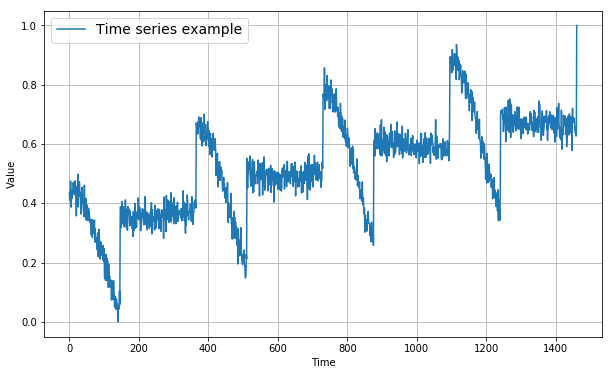

In [3]:
# The time series
time = np.arange(4 * 365 + 1)
baseline = 10
series = baseline + trend(time,0.5) + white_noise(time, noise_level=1, seed=0) + seasonality(time, period=365, amplitude=10, phase=0)
# Normalization
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(series.reshape(-1,1))
series = scaler.transform(series.reshape(-1,1))[0:,0]
# Plot
plt.figure(figsize=(10, 6))
plot_series(time, series, label='Time series example')
plt.show()

In [6]:
# Train and validation split
x_train = time[:1000]
y_train = series[:1000]
x_val = time[1000:]
y_val = series[1000:]

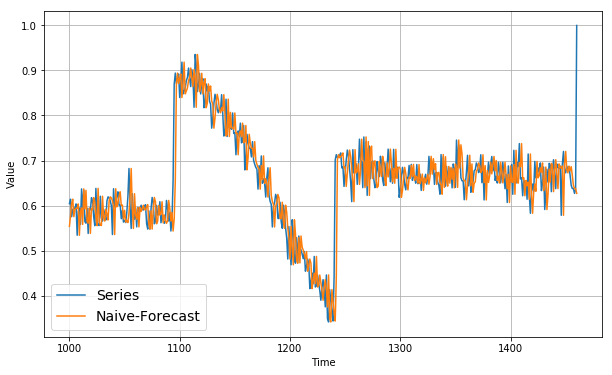

In [10]:
naive_forecast = series[1000 -2:-2]
plt.figure(figsize=(10, 6))
plot_series(x_val, y_val, label="Series")
plot_series(x_val, naive_forecast, label="Naive-Forecast")

In [11]:
from sklearn.metrics import mean_squared_error
sk_mse = mean_squared_error(y_val, naive_forecast)
print("Scikit-learn mse:", sk_mse)
import tensorflow as tf
tf_mse = tf.keras.metrics.mean_squared_error(y_val, naive_forecast).numpy()
print("tf.Keras mse:", tf_mse)

Scikit-learn mse: 0.0026973131835419176
tf.Keras mse: 0.0026973131835419176


In [12]:
# Moving average (MA)
def moving_average(series, window_size):
    forecast = []
    for time in range(len(series) - window_size):
        forecast.append(series[time:time + window_size].mean())
    return np.array(forecast)

# Faster implementation
#def moving_average_forecast(series, window_size):
#    mov = np.cumsum(series)
#   mov[window_size:] = mov[window_size:] - mov[:-window_size]
#    return mov[window_size - 1:-1] / window_size

0.005817871290599683


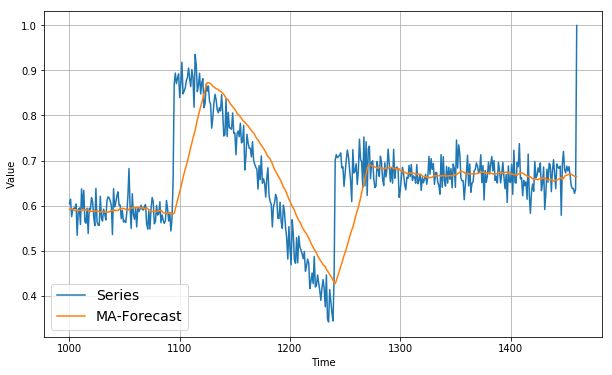

In [15]:
ma_forecast = moving_average(series, 30)[1000-30:]

plt.figure(figsize=(10, 6))
plot_series(x_val, y_val, label="Series")
plot_series(x_val, ma_forecast, label="MA-Forecast")
print(tf.keras.metrics.mean_squared_error(y_val, ma_forecast).numpy())

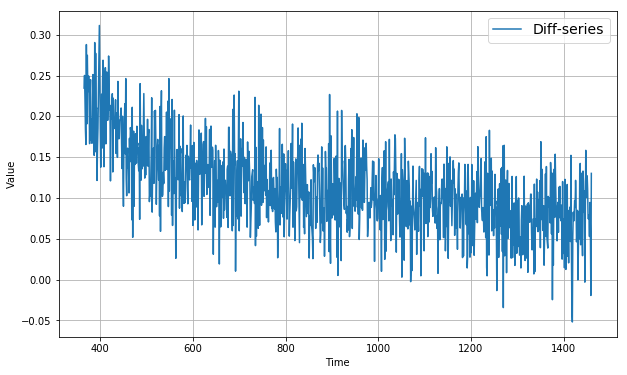

In [9]:
# Differencing: eliminate seasonality and trend
diff_series = (series[365:] - series[:-365])
diff_time = time[365:]

plt.figure(figsize=(10,6))
plot_series(diff_time, diff_series, label='Diff-series')

0.0016229547555533517


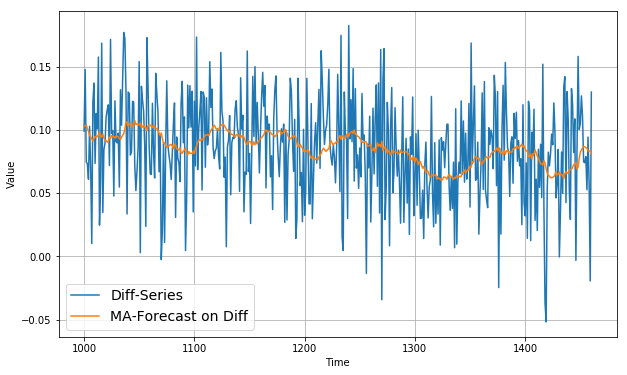

In [14]:
# Moving average after differencing
y_diff = diff_series[1000-365:]
diff_ma_forecast = moving_average(diff_series, 30)[1000-365-30:]
plt.figure(figsize=(10, 6))
plot_series(x_val, y_diff, label="Diff-Series")
plot_series(x_val, diff_ma_forecast, label="MA-Forecast on Diff")
print(mean_squared_error(y_diff, diff_ma_forecast))

0.0016229547555533517


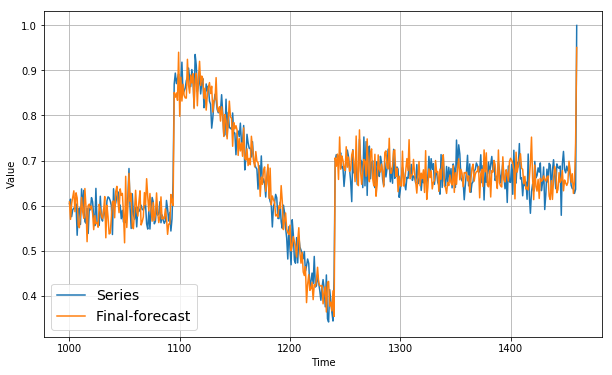

In [15]:
# De-differencing
final_forecast = diff_ma_forecast + series[1000-365:1000-365+len(y_val)]
plt.figure(figsize=(10, 6))
plot_series(x_val, y_val, label="Series")
plot_series(x_val, final_forecast, label="Final-forecast")
print(mean_squared_error(y_val, final_forecast))

0.0015006791455046073


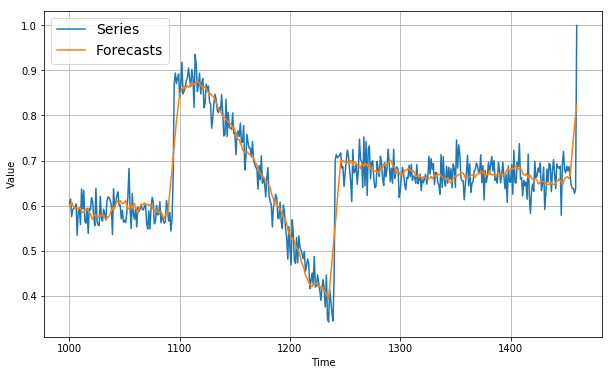

In [16]:
# Moving average on noise from 365 period ago
diff_moving_avg_plus_smooth_past = moving_average(series[1000 - 370:-359], 11) + diff_ma_forecast

plt.figure(figsize=(10, 6))
plot_series(x_val, y_val, label="Series")
plot_series(x_val, diff_moving_avg_plus_smooth_past, label="Forecasts")
print(mean_squared_error(y_val, diff_moving_avg_plus_smooth_past))